This script demonstrates the process of fine-tuning a pre-trained foundation model while modifying the input feature size to explore feature importance in predicting aerosol mixing state index (Chi). 
The experiment evaluates the impact of selected features by training on a subset of inputs and freezing intermediate model layers.

Key steps include:

1. **Data Preprocessing**:
   - Load MEGAPOLI Marine dataset for training and testing.
   - Set feature combination
   - Standardize features using the scaler fitted on the original PartMC dataset.

2. **Model Architecture**:
   - Adjust the ResNet input layer to match the new feature size while freezing the rest of the model.
   - Fine-tune the input and output layers and adjecent layers.

3. **Training and Fine-Tuning**:
   - Train the modified model using the fine-tuning training dataset.
   - Save the best model based on training loss.

4. **Evaluation**:
   - Evaluate the model on the MEGAPOLI test dataset using metrics: MSE, RMSE, MAE, R², and MAPE.

5. **Visualization**:
   - Plot actual vs. predicted Chi values over sample indices.
   - Create a scatter plot with density coloring for observed vs. predicted values.

This workflow enables the exploration of feature contributions to model performance, aiding in understanding the importance of specific chemical and environmental predictors in aerosol research.

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
import random

# Function to set random seed for reproducibility
def set_seed(seed):
    """
    Sets the random seed for reproducibility across numpy, random, and PyTorch.

    Parameters:
    - seed (int): The seed value to ensure reproducibility.
    """
    # Set seed for Python's built-in random module
    random.seed(seed)

    # Set seed for numpy
    np.random.seed(seed)

    # Set seed for PyTorch (CPU and GPU)
    torch.manual_seed(seed)  # CPU
    if torch.cuda.is_available():  # GPU
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)

    # Ensure deterministic behavior in PyTorch
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Set the random seed to ensure reproducibility
seed = 42  # Seed value for reproducibility
set_seed(seed)

### Different input feature subset combination

**All_features** = ['O3 (ppb)', 'CO (ppb)', 'NO (ppb)', 'NOx (ppb)',
        'ETH (ppb)', 'TOL(ppb)', 'XYL (ppb)', 'ALD2 (ppb)',
       'AONE (ppb)', 'PAR (ppb)', 'OLET (ppb)', 'Temperature(K)', 'RH',
       'BC (ug/m3)', 'OA (ug/m3)', 'NH4 (ug/m3)', 'NO3 (ug/m3)', 'SO4 (ug/m3)']

**Aerosol_only** = ['BC (ug/m3)', 'OA (ug/m3)', 'NH4 (ug/m3)', 'NO3 (ug/m3)', 'SO4 (ug/m3)']

**Drop_Aerosol** = ['O3 (ppb)', 'CO (ppb)', 'NO (ppb)', 'NOx (ppb)',
        'ETH (ppb)', 'TOL(ppb)', 'XYL (ppb)', 'ALD2 (ppb)',
       'AONE (ppb)', 'PAR (ppb)', 'OLET (ppb)', 'Temperature(K)', 'RH']

**Drop_Env** = ['O3 (ppb)', 'CO (ppb)', 'NO (ppb)', 'NOx (ppb)',
        'ETH (ppb)', 'TOL(ppb)', 'XYL (ppb)', 'ALD2 (ppb)',
       'AONE (ppb)', 'PAR (ppb)', 'OLET (ppb)',
       'BC (ug/m3)', 'OA (ug/m3)', 'NH4 (ug/m3)', 'NO3 (ug/m3)', 'SO4 (ug/m3)']

**Drop_Non-VOC** = ['ETH (ppb)', 'TOL(ppb)', 'XYL (ppb)', 'ALD2 (ppb)',
       'AONE (ppb)', 'PAR (ppb)', 'OLET (ppb)', 'Temperature(K)', 'RH',
       'BC (ug/m3)', 'OA (ug/m3)', 'NH4 (ug/m3)', 'NO3 (ug/m3)', 'SO4 (ug/m3)']

**Drop_VOC** = ['O3 (ppb)', 'CO (ppb)', 'NO (ppb)', 'NOx (ppb)',
        'Temperature(K)', 'RH','BC (ug/m3)', 'OA (ug/m3)', 'NH4 (ug/m3)', 'NO3 (ug/m3)', 'SO4 (ug/m3)']

**Drop_All_Gas** = ['Temperature(K)', 'RH', 'BC (ug/m3)', 'OA (ug/m3)', 'NH4 (ug/m3)', 'NO3 (ug/m3)', 'SO4 (ug/m3)']

In [ ]:
features = ['BC (ug/m3)', 'OA (ug/m3)', 'NH4 (ug/m3)', 'NO3 (ug/m3)', 'SO4 (ug/m3)']

# Load the dataset used for training the original model for Normalizing
partmc_train_data = pd.read_csv('../Data/PartMC_data/PartMC_train.csv')
X_train = partmc_train_data[features]


In [ ]:
# Load the datasets
megapoli_train_data = pd.read_csv('../Data/MEGAPOLI_data/MEGAPOLI_Marine_train_30%.csv')
megapoli_test_data = pd.read_csv('../Data/MEGAPOLI_data/MEGAPOLI_Marine_test_50%.csv')

# Prepare MEGAPOLI data
X_megapoli_train = megapoli_train_data[features]
y_megapoli_train = megapoli_train_data.iloc[:, 23]

X_megapoli_test = megapoli_test_data[features]
y_megapoli_test = megapoli_test_data.iloc[:, 23]

# Standardize the data using the scaler from the original model's training data
scaler_X = StandardScaler()
X_train2 = scaler_X.fit_transform(X_train)  #  Fit on the original training data, X_train2 ensures no need to reload the original dataset (PartMC)
X_megapoli_train = scaler_X.transform(X_megapoli_train)
X_megapoli_test = scaler_X.transform(X_megapoli_test)

# Convert to PyTorch tensors
X_megapoli_train_tensor = torch.tensor(X_megapoli_train, dtype=torch.float32)
y_megapoli_train_tensor = torch.tensor(y_megapoli_train, dtype=torch.float32)
X_megapoli_test_tensor = torch.tensor(X_megapoli_test, dtype=torch.float32)
y_megapoli_test_tensor = torch.tensor(y_megapoli_test, dtype=torch.float32)

# Convert to PyTorch tensors
X_megapoli_train_tensor = torch.tensor(X_megapoli_train, dtype=torch.float32)
y_megapoli_train_tensor = torch.tensor(y_megapoli_train, dtype=torch.float32)
X_megapoli_test_tensor = torch.tensor(X_megapoli_test, dtype=torch.float32)
y_megapoli_test_tensor = torch.tensor(y_megapoli_test, dtype=torch.float32)

# Create a DataLoader for the training data
batch_size = 1

megapoli_train_dataset = TensorDataset(X_megapoli_train_tensor, y_megapoli_train_tensor)
megapoli_train_loader = DataLoader(megapoli_train_dataset, batch_size=batch_size, shuffle=True)

# Define the ResNet-like model architecture
class ResNetBlock(nn.Module):
    def __init__(self, hidden_size):
        super(ResNetBlock, self).__init__()
        self.fc1 = nn.Linear(hidden_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, hidden_size)
    
    def forward(self, x):
        residual = x
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        out += residual
        out = self.relu(out)
        return out

class ResNet(nn.Module):
    def __init__(self, in_features, num_blocks, hidden_size):
        super(ResNet, self).__init__()
        self.fc_in = nn.Linear(in_features, hidden_size)
        self.relu = nn.ReLU()
        self.blocks = nn.Sequential(
            *[ResNetBlock(hidden_size) for _ in range(num_blocks)]
        )
        self.fc_out = nn.Linear(hidden_size, 1)
    
    def forward(self, x):
        out = self.fc_in(x)
        out = self.relu(out)
        out = self.blocks(out)
        out = self.fc_out(out)
        return out

# Load foundation model
input_size = 18
num_blocks = 15
hidden_size = 512
model = ResNet(input_size, num_blocks, hidden_size)
model.load_state_dict(torch.load('../Model/Foundation_Model.pth'))

# Adjusted input feature size
model.fc_in = nn.Linear(X_megapoli_train_tensor.shape[1], hidden_size)

# Freeze all layers except input and output layers
for param in model.parameters():
    param.requires_grad = False

for param in model.fc_in.parameters():
    param.requires_grad = True
for param in model.fc_out.parameters():
    param.requires_grad = True



# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.0001)

# Fine-tune the model
num_epochs =  25
best_mse = float('inf')
best_model = None

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for X_batch, y_batch in megapoli_train_loader:
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs.view(-1), y_batch)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        running_loss += loss.item() * X_batch.size(0)
    
    epoch_loss = running_loss / len(megapoli_train_loader.dataset)
    
        
    if epoch_loss < best_mse:
        best_mse = epoch_loss
        best_model = model.state_dict()
    
    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {epoch_loss:.4f}')

# 保存最佳模型
model.load_state_dict(best_model)
torch.save(model.state_dict(), '../Model/best_resnet_model_finetuned.pth')


Epoch 1/25, Train Loss: 0.0118
Epoch 2/25, Train Loss: 0.0041
Epoch 3/25, Train Loss: 0.0031
Epoch 4/25, Train Loss: 0.0025
Epoch 5/25, Train Loss: 0.0023
Epoch 6/25, Train Loss: 0.0019
Epoch 7/25, Train Loss: 0.0018
Epoch 8/25, Train Loss: 0.0016
Epoch 9/25, Train Loss: 0.0014
Epoch 10/25, Train Loss: 0.0013
Epoch 11/25, Train Loss: 0.0012
Epoch 12/25, Train Loss: 0.0011
Epoch 13/25, Train Loss: 0.0011
Epoch 14/25, Train Loss: 0.0010
Epoch 15/25, Train Loss: 0.0010
Epoch 16/25, Train Loss: 0.0009
Epoch 17/25, Train Loss: 0.0009
Epoch 18/25, Train Loss: 0.0008
Epoch 19/25, Train Loss: 0.0008
Epoch 20/25, Train Loss: 0.0008
Epoch 21/25, Train Loss: 0.0008
Epoch 22/25, Train Loss: 0.0007
Epoch 23/25, Train Loss: 0.0007
Epoch 24/25, Train Loss: 0.0007
Epoch 25/25, Train Loss: 0.0007


MSE: 0.0031, RMSE: 0.0559, R2: 0.4037, MAE: 0.0455, MAPE: 8.1506


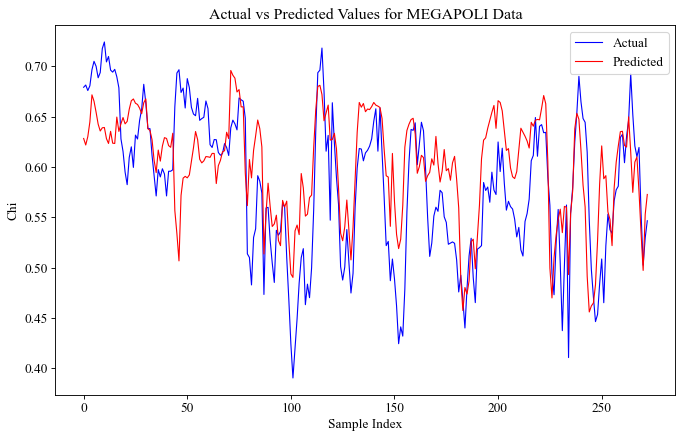

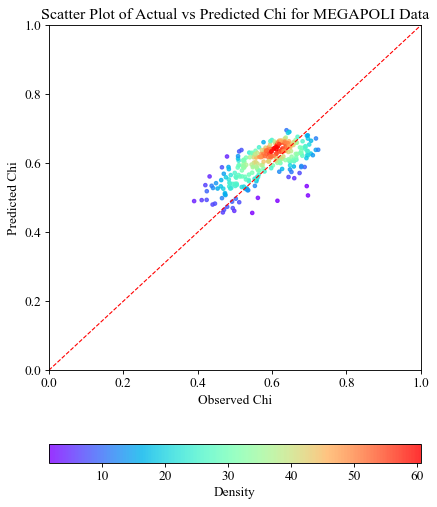

In [ ]:
# Evaluate on MEGAPOLI test data
model.eval()
with torch.no_grad():
    y_test_predictions = model(X_megapoli_test_tensor).view(-1)
    mse = mean_squared_error(y_megapoli_test_tensor.numpy(), y_test_predictions.numpy())
    rmse = np.sqrt(mse)
    r2 = r2_score(y_megapoli_test_tensor.numpy(), y_test_predictions.numpy())
    # r2 = 1 - mse / np.var(y_megapoli_test_tensor[0:298].numpy())
    mae = np.mean(np.abs(y_test_predictions.numpy() - y_megapoli_test_tensor.numpy()))
    mape = np.mean(np.abs((y_test_predictions.numpy() - y_megapoli_test_tensor.numpy()) / y_megapoli_test_tensor.numpy())) * 100

# Calculate performance metrics
# mse = mean_squared_error(y_test_true, y_test_pred)
# rmse = np.sqrt(mse)
# r2 = r2_score(y_test_true, y_test_pred)
# mae = mean_absolute_error(y_test_true, y_test_pred)
# mape = np.mean(np.abs((y_test_true - y_test_pred) / y_test_true)) * 100

mse, rmse, r2, mae, mape

print(f'MSE: {mse:.4f}, RMSE: {rmse:.4f}, R2: {r2:.4f}, MAE: {mae:.4f}, MAPE: {mape:.4f}')


# Visualization
plt.figure(figsize=(10, 6))
plt.plot(y_megapoli_test_tensor.numpy(), label='Actual', color='b')
plt.plot(y_test_predictions.numpy(), label='Predicted', color='r')
plt.xlabel('Sample Index')
plt.ylabel('Chi')
plt.title('Actual vs Predicted Values for MEGAPOLI Data')
plt.legend()
plt.show()


# Scatter plot with density
actual_values = y_megapoli_test_tensor.numpy()
predicted_values = y_test_predictions.numpy()
xy = np.vstack([actual_values, predicted_values])
z = gaussian_kde(xy)(xy)

fig, ax = plt.subplots(figsize=(6, 8)) 
scatter = plt.scatter(actual_values, predicted_values, c=z, s=10, cmap='rainbow', alpha=0.8)
plt.colorbar(scatter, label='Density', orientation='horizontal')
plt.plot([0, 1], [0, 1], color='r', linestyle='--')
plt.xlabel('Observed Chi')
plt.ylabel('Predicted Chi')
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.title('Scatter Plot of Actual vs Predicted Chi for MEGAPOLI Data')
plt.show()

In [147]:
print(X_megapoli_train_tensor.shape[1])

13


### Load fine-tuned Model

#### Different input feature subset combination

**All_features** = ['O3 (ppb)', 'CO (ppb)', 'NO (ppb)', 'NOx (ppb)',
        'ETH (ppb)', 'TOL(ppb)', 'XYL (ppb)', 'ALD2 (ppb)',
       'AONE (ppb)', 'PAR (ppb)', 'OLET (ppb)', 'Temperature(K)', 'RH',
       'BC (ug/m3)', 'OA (ug/m3)', 'NH4 (ug/m3)', 'NO3 (ug/m3)', 'SO4 (ug/m3)']

**Aerosol_only** = ['BC (ug/m3)', 'OA (ug/m3)', 'NH4 (ug/m3)', 'NO3 (ug/m3)', 'SO4 (ug/m3)']

**Drop_Aerosol** = ['O3 (ppb)', 'CO (ppb)', 'NO (ppb)', 'NOx (ppb)',
        'ETH (ppb)', 'TOL(ppb)', 'XYL (ppb)', 'ALD2 (ppb)',
       'AONE (ppb)', 'PAR (ppb)', 'OLET (ppb)', 'Temperature(K)', 'RH']

**Drop_Env** = ['O3 (ppb)', 'CO (ppb)', 'NO (ppb)', 'NOx (ppb)',
        'ETH (ppb)', 'TOL(ppb)', 'XYL (ppb)', 'ALD2 (ppb)',
       'AONE (ppb)', 'PAR (ppb)', 'OLET (ppb)',
       'BC (ug/m3)', 'OA (ug/m3)', 'NH4 (ug/m3)', 'NO3 (ug/m3)', 'SO4 (ug/m3)']

**Drop_Non-VOC** = ['ETH (ppb)', 'TOL(ppb)', 'XYL (ppb)', 'ALD2 (ppb)',
       'AONE (ppb)', 'PAR (ppb)', 'OLET (ppb)', 'Temperature(K)', 'RH',
       'BC (ug/m3)', 'OA (ug/m3)', 'NH4 (ug/m3)', 'NO3 (ug/m3)', 'SO4 (ug/m3)']

**Drop_VOC** = ['O3 (ppb)', 'CO (ppb)', 'NO (ppb)', 'NOx (ppb)',
        'Temperature(K)', 'RH','BC (ug/m3)', 'OA (ug/m3)', 'NH4 (ug/m3)', 'NO3 (ug/m3)', 'SO4 (ug/m3)']

**Drop_All_Gas** = ['Temperature(K)', 'RH', 'BC (ug/m3)', 'OA (ug/m3)', 'NH4 (ug/m3)', 'NO3 (ug/m3)', 'SO4 (ug/m3)']

In [18]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
import random


features = ['Temperature(K)', 'RH', 'BC (ug/m3)', 'OA (ug/m3)', 'NH4 (ug/m3)', 'NO3 (ug/m3)', 'SO4 (ug/m3)']

# Load the dataset used for training the original model for Normalizing
partmc_train_data = pd.read_csv('../Data/PartMC_data/PartMC_train.csv')
X_train = partmc_train_data[features]

# Load the datasets
megapoli_train_data = pd.read_csv('../Data/MEGAPOLI_data/MEGAPOLI_Marine_train_50%.csv')
megapoli_test_data = pd.read_csv('../Data/MEGAPOLI_data/MEGAPOLI_Marine_test_50%.csv')

# Prepare MEGAPOLI data
X_megapoli_train = megapoli_train_data[features]
y_megapoli_train = megapoli_train_data.iloc[:, 23]

X_megapoli_test = megapoli_test_data[features]
y_megapoli_test = megapoli_test_data.iloc[:, 23]

# Standardize the data
scaler_X = StandardScaler()
X_train2 = scaler_X.fit_transform(X_train)
X_megapoli_train = scaler_X.transform(X_megapoli_train)
X_megapoli_test = scaler_X.transform(X_megapoli_test)


# Convert to PyTorch tensors
X_megapoli_train_tensor = torch.tensor(X_megapoli_train, dtype=torch.float32)
y_megapoli_train_tensor = torch.tensor(y_megapoli_train, dtype=torch.float32)
X_megapoli_test_tensor = torch.tensor(X_megapoli_test, dtype=torch.float32)
y_megapoli_test_tensor = torch.tensor(y_megapoli_test, dtype=torch.float32)

In [19]:
# Define ResNet-like model
class ResNetBlock(nn.Module):
    def __init__(self, hidden_size):
        super(ResNetBlock, self).__init__()
        self.fc1 = nn.Linear(hidden_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, hidden_size)
    
    def forward(self, x):
        residual = x
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        out = out + residual
        out = self.relu(out)
        return out

class ResNet(nn.Module):
    def __init__(self, in_features, num_blocks, hidden_size):
        super(ResNet, self).__init__()
        self.fc_in = nn.Linear(in_features, hidden_size)
        self.relu = nn.ReLU()
        self.blocks = nn.Sequential(
            *[ResNetBlock(hidden_size) for _ in range(num_blocks)]
        )
        self.fc_out = nn.Linear(hidden_size, 1)
    
    def forward(self, x):
        out = self.fc_in(x)
        out = self.relu(out)
        out = self.blocks(out)
        out = self.fc_out(out)
        return out

# Load pre-trained model
input_size = X_megapoli_train_tensor.shape[1]
num_blocks = 15
hidden_size = 512
model = ResNet(input_size, num_blocks, hidden_size)
model.load_state_dict(torch.load('../Model/best_resnet_model_finetuned_50%_7_DropAllGas.pth'))

C:\Users\1\AppData\Local\Temp\ipykernel_10440\2649018815.py:40: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('../Model/best_resnet_model_fi

<All keys matched successfully>

In [20]:
# Evaluate on MEGAPOLI test data
model.eval()
with torch.no_grad():
    y_test_predictions = model(X_megapoli_test_tensor).view(-1)
    mse = mean_squared_error(y_megapoli_test_tensor.numpy(), y_test_predictions.numpy())
    rmse = np.sqrt(mse)
    r2 = r2_score(y_megapoli_test_tensor.numpy(), y_test_predictions.numpy())
    # r2 = 1 - mse / np.var(y_megapoli_test_tensor[0:298].numpy())
    mae = np.mean(np.abs(y_test_predictions.numpy() - y_megapoli_test_tensor.numpy()))
    mape = np.mean(np.abs((y_test_predictions.numpy() - y_megapoli_test_tensor.numpy()) / y_megapoli_test_tensor.numpy())) * 100

# Calculate performance metrics
# mse = mean_squared_error(y_test_true, y_test_pred)
# rmse = np.sqrt(mse)
# r2 = r2_score(y_test_true, y_test_pred)
# mae = mean_absolute_error(y_test_true, y_test_pred)
# mape = np.mean(np.abs((y_test_true - y_test_pred) / y_test_true)) * 100

mse, rmse, r2, mae, mape

print(f'MSE: {mse:.4f}, RMSE: {rmse:.4f}, R2: {r2:.4f}, MAE: {mae:.4f}, MAPE: {mape:.4f}')

# Convert to numpy arrays
y_true = y_megapoli_test_tensor.numpy()
y_pred = y_test_predictions.numpy()

# Create a DataFrame
results_df = pd.DataFrame({
    'y_true': y_true,
    'y_pred': y_pred
})

# Save to CSV
results_df.to_csv('../Data/Fine_tuned_Results_different_input_feature/Fine_tuning_DropAllGas_Data.csv', index=False)








MSE: 0.0023, RMSE: 0.0480, R2: 0.4686, MAE: 0.0398, MAPE: 7.4457
